# Demo of End-to-End Time Domain Audio with fastai

> Note: some parts of this document are not rendered. Click the "Open in Colab" badge to see everything.


---

Work in progress. If you come back later there'll probably be more. - SHH, 10/24/21.

---

There are many tutorials on doing audio classification; usually these invovle rendering your audio as (mel-)spectrograms and doing image classification on those.   There are not as many tutorials on doing audio processing or generation but [there's been a growing list](https://twitter.com/drscotthawley/status/1451968159565680648?s=20).  Lately I've become somewhat proficient with fastai and would like to port some audio processing examples over to it.  There are a few choices for tasks and datasets -- great work on source separation, for example.


## My Choice&#58; Reproduce Micro-TCN

Since I've been interested in audio effects, I'll choose the task of reproducing Christian Steinmetz and Josh Reiss's [Micro-TCN](https://github.com/csteinmetz1/micro-tcn) work for learning to profile audio compressors. That code uses PyTorch Lightning instead of fastai. We should be able to do the bare minimum integration with fastai by following [Zach Mueller's prescription](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html).  The experience gained from doing this can hopefully serve when adapting other audio tasks & models to work with fastai. 

### Other things we could try (in later notebooks)
We could just grab any old audio data and then we could learn some kind of inverse effect such as denoising: we could add noise to the audio files and then train the network to remove the noise.  But what other audio datasets are available? 

* [torchaudio datasets](https://pytorch.org/audio/stable/datasets.html). These are almost all about speech; only GTZAN is musical.  
* [Source separation datasets](https://source-separation.github.io/tutorial/data/datasets.html), i.e. mono-to-many
* [ISMIR has a list of datasets](https://ismir.net/resources/datasets/)
* We can always grab audio and then use Spotify's new [Pedalboard](https://github.com/spotify/pedalboard) to add effects
* [Marco Martinez' Leslie effects dataset](https://zenodo.org/record/3562442) is a bit less than 1 GB. It has "dry" (input) and various target output directories such as "tremelo".

In [ ]:
#hide
#all_slow

## Installs and imports

In [ ]:
#show 
# Next line only executes on Colab. Colab users: Please enable GPU in Edit > Notebook settings
! [ -e /content ] && pip install -Uqq pip fastai git+https://github.com/drscotthawley/fastproaudio.git

# Additional installs for this tutorial
%pip install -q fastai_minima torchsummary pyzenodo3 wandb

# Install micro-tcn and auraloss packages (from source, will take a little while)
%pip install -q wheel --ignore-requires-python git+https://github.com/csteinmetz1/micro-tcn.git  git+https://github.com/csteinmetz1/auraloss

# After this cell finishes, restart the kernel and continue below

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.callback.fp16 import *
import wandb
from fastai.callback.wandb import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio 
import matplotlib.pyplot as plt
import torchsummary
from fastproaudio.core import *
from glob import glob
import json

use_fastaudio = False
if use_fastaudio:
    from fastaudio.core.all import *
    from fastaudio.augment.all import *
    from fastaudio.ci import skip_if_ci

## Download and Inspect the Data 

The "SignalTrain LA2A Reduced" dataset is something I made Friday night. It's only the first 10 seconds of each of the 20-minute audio files making up the full [SignalTrain LA2A](http://localhost:8888/notebooks/(https://zenodo.org/record/3824876) dataset, which consists of lots of audio files run through an [LA2A audio compressor](https://www.uaudio.com/hardware/la-2a.html) at different knob settings. At 200 MB, the Reduced version is enough to train the model some and see that it's working for the purposes of this demo, though you'd probably want more data to make a high-quality model.  (If you'd rather train using the full 20 GB dataset, use `URLs.SIGNALTRAIN_LA2A_1_1` below, but everything will take longer!)

In [ ]:
path = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED); path

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

In [ ]:
fnames_in = sorted(glob(str(path)+'/*/input*'))
fnames_targ = sorted(glob(str(path)+'/*/*targ*'))
ind = -1   # pick one spot in the list of files
fnames_in[ind], fnames_targ[ind]

('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/input_260_.wav',
 '/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/target_260_LA2A_2c__1__85.wav')

**Input audio**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.225,  Min: -0.218, Mean:  0.000, Std Dev:  0.038


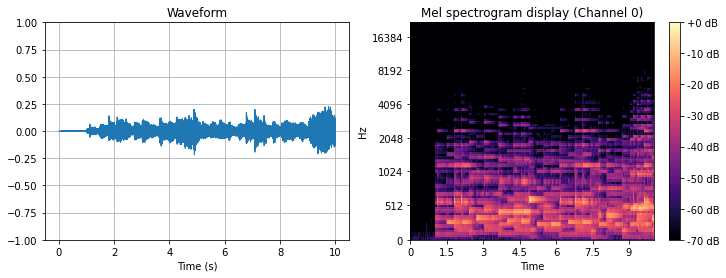

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)   # turn off annoying matplotlib warnings

waveform, sample_rate = torchaudio.load(fnames_in[ind])
show_audio(waveform, sample_rate)

**Target output audio**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.091,  Min: -0.103, Mean: -0.000, Std Dev:  0.021


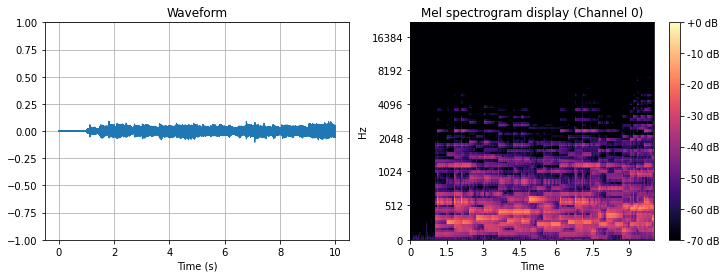

In [ ]:
target, sr_targ = torchaudio.load(fnames_targ[ind])
show_audio(target, sr_targ)

Let's look at the difference.

**Difference**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.144,  Min: -0.159, Mean: -0.000, Std Dev:  0.018


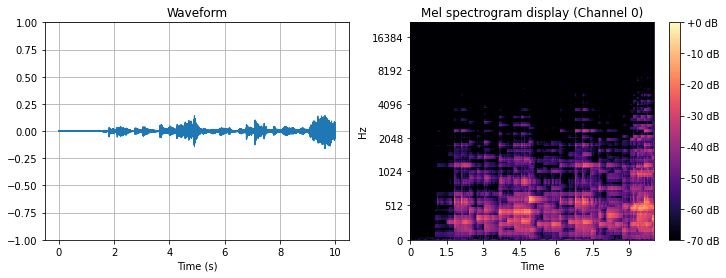

In [ ]:
show_audio(target - waveform, sample_rate)

## Import Steinmetz's Code (and make it work with fastai)

**Datasets and Dataloader definitions:** These use `micro-tcn`'s custom [SignalTrainLA2ADataset](https://github.com/csteinmetz1/micro-tcn/blob/6f2c9a8da33590bdc496b8ea7aee4f268ee8da14/microtcn/data.py#L10) class.  Each Dataset object returns 3 items from `__getitem__()`: `input`, `target`, and `params`.  To make our lives easier with fastai, we're going to "pack" the `input` and the `params` together with our own subclassed Dataset, then we'll have the model unpack them later.

In [ ]:
from microtcn.data import SignalTrainLA2ADataset

class SignalTrainLA2ADataset_fastai(SignalTrainLA2ADataset):
    "For fastai's sake, have getitem pack the inputs and params together"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, idx):
        input, target, params = super().__getitem__(idx)
        return torch.cat((input,params),dim=-1), target   # pack input and params together

In [ ]:
class Args(object):  # stand-in for parseargs. these are all micro-tcn defaults
    model_type ='tcn'
    root_dir = str(path)
    preload = False
    sample_rate = 44100
    shuffle = True
    train_subset = 'train'
    val_subset = 'val'
    train_length = 65536
    train_fraction = 1.0
    eval_length = 131072
    batch_size = 8   # original is 32, my laptop needs smaller, esp. w/o half precision
    num_workers = 4
    precision = 32  # LEAVE AS 32 FOR NOW: HALF PRECISION (16) NOT WORKING YET -SHH
    n_params = 2
    
args = Args()

#if args.precision == 16:  torch.set_default_dtype(torch.float16)

# setup the dataloaders
train_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    subset=args.train_subset, 
                    fraction=args.train_fraction,
                    half=True if args.precision == 16 else False, 
                    preload=args.preload, 
                    length=args.train_length)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                    shuffle=args.shuffle,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

val_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset=args.val_subset,
                    length=args.eval_length)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

[(0.0, 0.0), (0.0, 5.0), (0.0, 15.0), (0.0, 20.0), (0.0, 25.0), (0.0, 30.0), (0.0, 35.0), (0.0, 40.0), (0.0, 45.0), (0.0, 55.0), (0.0, 60.0), (0.0, 65.0), (0.0, 70.0), (0.0, 75.0), (0.0, 80.0), (0.0, 85.0), (0.0, 90.0), (0.0, 95.0), (0.0, 100.0), (1.0, 0.0), (1.0, 5.0), (1.0, 15.0), (1.0, 20.0), (1.0, 25.0), (1.0, 30.0), (1.0, 35.0), (1.0, 40.0), (1.0, 45.0), (1.0, 50.0), (1.0, 55.0), (1.0, 60.0), (1.0, 65.0), (1.0, 75.0), (1.0, 80.0), (1.0, 85.0), (1.0, 90.0), (1.0, 95.0), (1.0, 100.0)]
Total Examples: 396     Total classes: 38
Fraction examples: 396    Examples/class: 10
Training with 0.25 min per class    Total of 9.41 min
Located 380 examples totaling 9.41 min in the train subset.
Located 45 examples totaling 2.23 min in the val subset.


If the user requested fp16 precision then we need to install NVIDIA apex:

In [ ]:
if False and args.precision == 16:
    %pip install -q --disable-pip-version-check --no-cache-dir git+https://github.com/NVIDIA/apex
    from apex.fp16_utils import convert_network

### Define the model(s)
Christian defined a lot of models. We'll do the TCN-300 ~~and the LSTM~~. 

In [ ]:
from microtcn.tcn_bare import TCNModel as TCNModel
#from microtcn.lstm import LSTMModel # actually the LSTM depends on a lot of Lightning stuff, so we'll skip that
from microtcn.utils import center_crop, causal_crop

class TCNModel_fastai(TCNModel):
    "For fastai's sake, unpack the inputs and params"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, x, p=None):
        if (p is None) and (self.nparams > 0):  # unpack the params if needed
            assert len(list(x.size())) == 3   # sanity check 
            x, p = x[:,:,0:-self.nparams], x[:,:,-self.nparams:]
        return super().forward(x, p=p)

In [ ]:
#show
# micro-tcn defines several different model configurations. I just chose one of them. 
train_configs = [
      {"name" : "TCN-300",
     "model_type" : "tcn",
     "nblocks" : 10,
     "dilation_growth" : 2,
     "kernel_size" : 15,
     "causal" : False,
     "train_fraction" : 1.00,
     "batch_size" : args.batch_size
    }
]

dict_args = train_configs[0]
dict_args["nparams"] = 2

model = TCNModel_fastai(**dict_args)
dtype = torch.float32

Let's take a look at the model:

In [ ]:
#show
# this summary allows one to compare the original TCNModel with the TCNModel_fastai
if type(model) == TCNModel_fastai:
    torchsummary.summary(model, [(1,args.train_length)], device="cpu")
else:
    torchsummary.summary(model, [(1,args.train_length),(1,2)], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 32]             544
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 32]           1,056
              ReLU-6                [-1, 1, 32]               0
            Conv1d-7            [-1, 32, 65520]             480
            Linear-8                [-1, 1, 64]           2,112
       BatchNorm1d-9            [-1, 32, 65520]               0
             FiLM-10            [-1, 32, 65520]               0
            PReLU-11            [-1, 32, 65520]              32
           Conv1d-12            [-1, 32, 65534]              32
         TCNBlock-13            [-1, 32, 65520]               0
           Conv1d-14            [-1, 32

### Getting the model into fastai form

Zach Mueller made a very helpful [fastai_minima](https://muellerzr.github.io/fastai_minima/) package that we'll use, and follow his instructions.  

> **TODO:** Zach says I should either use `fastai` or `fastai_minima`, not mix them like I'm about to do. But what I have below is the only thing that *works* right now. ;-) 

In [ ]:
#show
# I guess we could've imported these up at the top of the notebook...
from torch import optim
from fastai_minima.optimizer import OptimWrapper
#from fastai_minima.learner import Learner  # this doesn't include lr_find()
from fastai.learner import Learner
from fastai_minima.learner import DataLoaders
#from fastai_minima.callback.training_utils import CudaCallback, ProgressCallback # note sure if I need these

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(optim.SGD(params, **kwargs))

dls = DataLoaders(train_dataloader, val_dataloader)

### Checking: Let's make sure the Dataloaders are working

In [ ]:
if args.precision==16: 
    dtype = torch.float16
    model = convert_network(model, torch.float16)

model = model.to('cuda:0')
if type(model) == TCNModel_fastai:
    print("We're using Hawley's modified code")
    packed, targ = dls.one_batch()
    inp, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
else:
    print("We're using Christian's version of Dataloader and model")
    inp, targ, params = dls.one_batch()
    pred = model.forward(inp.to('cuda:0',dtype=dtype), p=params.to('cuda:0', dtype=dtype))
print(f"input  = {inp.size()}\ntarget = {targ.size()}\nparams = {params.size()}\npred   = {pred.size()}")

We're using Hawley's modified code
input  = torch.Size([8, 1, 65536])
target = torch.Size([8, 1, 65536])
params = torch.Size([8, 1, 2])
pred   = torch.Size([8, 1, 51214])


We can make the pred and target the same length by cropping when we compute the loss:

In [ ]:
class Crop_Loss:
    "Crop target size to match preds"
    def __init__(self, axis=-1, causal=False, reduction="mean", func=nn.L1Loss):
        store_attr()
        self.loss_func = func()
    def __call__(self, pred, targ):
        targ = causal_crop(targ, pred.shape[-1]) if self.causal else center_crop(targ, pred.shape[-1])
        #pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, f'pred.shape = {pred.shape} but targ.shape = {targ.shape}'
        return self.loss_func(pred,targ).flatten().mean() if self.reduction == "mean" else loss(pred,targ).flatten().sum()
    

# we could add a metric like MSE if we want
def crop_mse(pred, targ, causal=False): 
    targ = causal_crop(targ, pred.shape[-1]) if causal else center_crop(targ, pred.shape[-1])
    return ((pred - targ)**2).mean()

#### Enable logging with WandB:

In [ ]:
wandb.login()

wandb: Currently logged in as: drscotthawley (use `wandb login --relogin` to force relogin)


True

## Define the fastai Learner and callbacks

We're going to add a new custom WandBAudio callback futher below, that we'll uses when we call `fit()`.

#### WandBAudio Callback
In order to log audio samples, let's write our own audio-logging callback for fastai:

In [ ]:
class WandBAudio(Callback):
    """Progress-like callback: log audio to WandB"""
    order = ProgressCallback.order+1
    def __init__(self, n_preds=5, sample_rate=44100):
        store_attr()

    def after_epoch(self):  
        if not self.learn.training:
            with torch.no_grad():
                preds, targs = [x.detach().cpu().numpy().copy() for x in [self.learn.pred, self.learn.y]]
            log_dict = {}
            for i in range(min(self.n_preds, preds.shape[0])): # note wandb only supports mono
                    log_dict[f"preds_{i}"] = wandb.Audio(preds[i,0,:], caption=f"preds_{i}", sample_rate=self.sample_rate)
            wandb.log(log_dict)

#### Learner and wandb init

In [ ]:
wandb.init(project='micro-tcn-fastai')#  no name, name=json.dumps(dict_args))

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func,
               cbs= [WandbCallback()])

## Train the model

We can use the fastai learning rate finder to suggest a learning rate:

SuggestedLRs(valley=0.0006918309954926372)

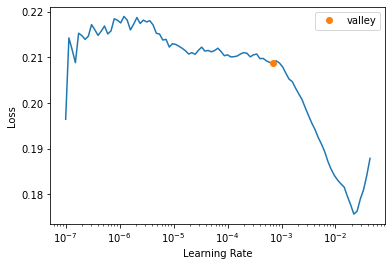

In [ ]:
learn.lr_find(end_lr=0.1) 

And now we'll train using the one-cycle LR schedule, with the WandBAudio callback. (Ignore any warning messages)

In [ ]:
epochs = 20  # change to 50 for better results but a longer wait
learn.fit_one_cycle(epochs, lr_max=3e-3, cbs=WandBAudio(sample_rate=args.sample_rate))

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 


In [ ]:
wandb.finish() # call wandb.finish() after training or your logs may be incomplete

In [ ]:
learn.save('micro-tcn-fastai')

Path('models/micro-tcn-fastai.pth')

Go check out the resulting run logs, graphs, and audio samples at https://wandb.ai/drscotthawley/micro-tcn-fastai, or...
lemme see if I can embed some results below:

In [ ]:
#hide
from IPython.display import HTML
HTML('<iframe src="https://wandb.ai/drscotthawley/micro-tcn-fastai/reports/micro-tcn-fastai-results--VmlldzoxMTUwNDg3" style="border:none;height:1024px;width:100%">')

...ok it looks like the WandB results iframe (with cool graphs & audio) is getting filtered out of the docs (by nbdev and/or jekyll), but if you open this notebook file -- e.g. click the "Open in Colab" badge at the top -- then scroll down and you'll see the report. Or just go to the WandB link posted above!

## TODO: Inference / Evaluation / Analysis

Load in the testing data

In [ ]:
test_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset='test',
                    length=args.eval_length)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func, cbs=[])
learn.load('micro-tcn-fastai')

Located 9 examples totaling 0.45 min in the test subset.


^^ 9 examples?  I thought there were only 3:

In [ ]:
!ls {path}/Test

input_235_.wav	input_259_.wav		       target_256_LA2A_2c__1__65.wav
input_256_.wav	target_235_LA2A_2c__0__65.wav  target_259_LA2A_2c__1__80.wav


...Ok I don't understand that yet. Moving on:

Let's get some predictions from the model. Note that the length of these predictions will greater than in training, because we specified them differently:

In [ ]:
print(args.train_length, args.eval_length)

65536 131072


Handy routine to grab some data and run it through the model to get predictions:

In [ ]:
def get_batch(dataloader, crop_target=True, causal=False):
    packed, target = next(iter(dataloader))
    input, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
    if crop_target: target = causal_crop(target, pred.shape[-1]) if causal else center_crop(target, pred.shape[-1])
    input, params, target, pred = [x.detach().cpu() for x in [input, params, target, pred]]
    return input, params, target, pred

------- i = 0 ---------

prediction:
Shape: (1, 116750), Dtype: torch.float32, Duration: 2.647392290249433 s
Max:  0.135,  Min: -0.157, Mean:  0.000, Std Dev:  0.037


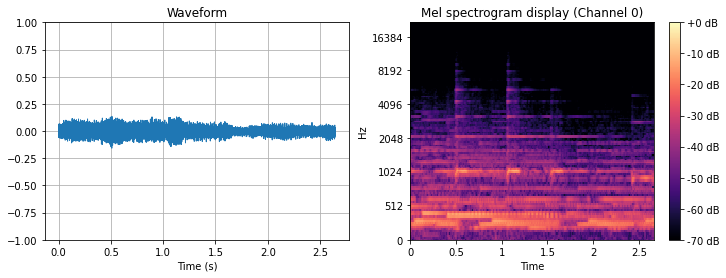

In [ ]:
input, params, target, pred = get_batch(test_dataloader, causal=dict_args['causal'])
i = 0  # just look at the first element
print(f"------- i = {i} ---------\n")
print(f"prediction:")
show_audio(pred[i], sample_rate)

target:
Shape: (1, 116750), Dtype: torch.float32, Duration: 2.647392290249433 s
Max:  0.215,  Min: -0.202, Mean:  0.000, Std Dev:  0.053


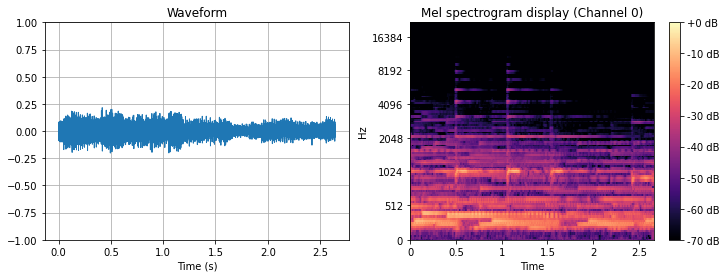

In [ ]:
print(f"target:")
show_audio(target[i], sample_rate)

## Deployment / Plugins

Check out [Christian's GitHub page for micro-tcn](https://github.com/csteinmetz1/micro-tcn#plugin) where he provides instructions and JUCE files by which to render the model as an audio plugin.  Pretty sure you can only do this with the causal models, which I didn't include -- yet! 